In [161]:
from gridworld import GridworldEnv
from Algorithms.single_q_learning import SingleQLearning
from Algorithms.double_q_learning import DoubleQLearning

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import csv

import time

In [162]:
env = GridworldEnv()
n = 50

def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

List all games

For each game, run double q and single q, over 10 random seeds and save results
Metrics are:
episode returns (/time)
episode lengths (/time) ?


In [163]:
def experiment(env, env_name='', save_dir='Results'):
    # Define games and hyperparams
    
    # Get results for test
    single_results, double_results = run_experiment(env)

    # Save Results to csv
    save_results(env_name, single_results, double_results, save_dir=save_dir)

    # Plot results
    plot_results(single_results, double_results)
    
    return


In [175]:
def run_experiment(env, policy=None, seeds=None, params : dict = None, ):
   
    # If no seeds are provided, simply take the indices of the runs
    if seeds is None:
        seeds = [i for i in range(10)]

    # Obtain results for each random seed
    single_lengths = []
    single_returns = []
    double_lengths = []
    double_returns = []
    
    for i in seeds:
        np.random.seed(i)
        single_result, double_result = single_run(env, params=params)
        single_lengths.append(single_result[0])
        single_returns.append(single_result[1])
        double_lengths.append(double_result[0])
        double_returns.append(double_result[1])
        

    return (single_lengths, single_returns), (double_lengths, double_returns)


In [180]:
def process_results(results):
    lengths = np.array(results[0])
    mean_lengths, std_lengths = get_stats(lengths)
    
    returns = np.array(results[1])
    mean_returns, std_returns = get_stats(lengths)

    return (mean_lengths, std_lengths), (mean_returns, std_returns)


def get_stats(data):
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mean, std


def save_results(env_name, single_results, double_results, save_dir='Results'):
    os.makedirs(save_dir, exist_ok=True)
    write_result(env_name, single_results[0], 'Single Lengths')
    write_result(env_name, single_results[1], 'Single Returns')
    write_result(env_name, double_results[0], 'Double Lengths')
    write_result(env_name, double_results[1], 'Double Returns')
    return


def write_result(env_name, results, header, save_dir='Results', file_id=''):
    file_name = env_name + '_' + header + file_id + '.csv'
    file_path = os.path.join(save_dir, file_name)

    with open(file_path, 'w') as file:
        writer = csv.writer(file)
        header = [header] + [i for i in range(len(results[0]))]
        writer.writerow(header)

        for j in range(len(results)):
            row = [j] + list(results[j])
            writer.writerow(row)
        mean, std = get_stats(results)
        mean_row = ['Mean'] + mean.tolist()
        std_row = ['Std. Dev.'] + std.tolist()
        writer.writerow(mean_row)
        writer.writerow(std_row)

    return


In [181]:
def single_run(env, policy=None, params : dict = None):
    if params is None:
        params = {}

    epsilon = params.setdefault('epsilon', 0.1)
    num_episodes = params.setdefault('num_episodes', 100)
    discount_factor = params.setdefault('discount_factor', 1)
    alpha = params.setdefault('alpha', 0.1)
    
    # For a single run, obtain all metrics and return
    single_q_vals, single_q_results = single_q(env, policy=policy, epsilon=epsilon, num_episodes=num_episodes, discount_factor=discount_factor, alpha=alpha)
    double_q_vals, double_q_results = double_q(env, policy=policy, epsilon=epsilon, num_episodes=num_episodes, discount_factor=discount_factor, alpha=alpha)
    return (single_q_results, double_q_results)

        
def double_q(env, policy=None, epsilon=0.1, num_episodes=1000, discount_factor=1, alpha=0.1):
        Q_a = np.zeros((env.nS, env.nA))
        Q_b = np.zeros((env.nS, env.nA))

        if policy is None:
            policy = DoubleQLearning.EpsilonGreedyPolicy(Q_a, Q_b, epsilon=epsilon)

        Q_values, (episode_lengths, episode_returns) = \
            DoubleQLearning.double_q_learning(env, policy, Q_a, Q_b, num_episodes, discount_factor=discount_factor, alpha=alpha)
        return  Q_values, (episode_lengths, episode_returns)


def single_q(env, policy=None, epsilon=0.1, num_episodes=1000, discount_factor=1, alpha=0.1):
        Q = np.zeros((env.nS, env.nA))
        
        if policy is None:
            policy = SingleQLearning.EpsilonGreedyPolicy(Q, epsilon=epsilon)

        Q_values, (episode_lengths, episode_returns) = \
            SingleQLearning.single_q_learning(env, policy, Q, num_episodes, discount_factor=discount_factor, alpha=alpha)
        return Q_values, (episode_lengths, episode_returns)

plot metrics and save figures

In [182]:
def plot_results(single_results, double_results, file_path='Results/', file_id='', file_type='.png', save=True, show=False):
    # A comparison of double_Q vs single_Q over all runs
    # A comparison of the first half of single against itself and double against itself
    # A comparison of the first half of double and single vs the second half

    (mean_single_lengths, std_single_lengths), (mean_single_returns, std_single_returns) = process_results(single_results)
    (mean_double_lengths, std_double_lengths), (mean_double_returns, std_double_returns) = process_results(double_results)

    # So 3x2 plots
    fig = plt.figure()
    # fig.suptitle("Results")

    # plt.text("Episode Returns")
    # plt.text("Episode Lengths")
    # A comparison of episode returns for single_Q vs double_Q over all runs
    fig.add_subplot(211)
    plot_metric("Episode Returns", mean_single_returns, std_single_returns, mean_double_returns, std_double_returns)

    # A Comparison of episode lengths for single_Q vs double_Q over all runs
    fig.add_subplot(212)
    plot_metric("Episode Lengths", mean_single_lengths, std_single_lengths, mean_double_lengths, std_double_lengths)

 

    # # A comparison of the episode returns for different random seeds for single Q 
    # fig.add_subplot(323)
    # plot_metric(single_q_returns[:half], single_q_returns[half:])

    # # A comparison of the episode lengths for different random seeds for single Q
    # fig.add_subplot(324)
    # plot_metric(single_q_lengths[:half], single_q_lengths[half:])

    # # A comparison of the episode returns for different random seeds for double Q 
    # fig.add_subplot(325)
    # plot_metric(double_q_returns[:half], double_q_returns[half:])

    # # A comparison of the episode lengths for different random seeds for double Q 
    # fig.add_subplot(326)
    # plot_metric(double_q_lengths[:half], double_q_lengths[half:])
    plt.show()
    return


def plot_metric(title, single_mean, single_std, double_mean, double_std, file_path='Results/', file_id='', file_type='.png', save=False, show=False):

    plt.plot(single_mean)
    plt.fill_between(range(len(single_mean)), single_mean - single_std, single_mean + single_std, alpha=0.3)
    plt.plot(double_mean)
    plt.fill_between(range(len(single_mean)), double_mean - double_std, double_mean + double_std, alpha=0.3)
    plt.title(title)
    plt.legend(['Single Q-Learning', "Double Q-learning"])

    if save:
        import os
        os.makedirs(file_path)
        filename = file_path + title + file_id+file_type
        plt.savefig(filename)

    if show:
        plt.show()

    return

100%|██████████| 100/100 [00:00<00:00, 2088.89it/s]


100


100%|██████████| 100/100 [00:00<00:00, 2785.15it/s]


100


100%|██████████| 100/100 [00:00<00:00, 2088.98it/s]


100


100%|██████████| 100/100 [00:00<00:00, 3234.45it/s]


100


100%|██████████| 100/100 [00:00<00:00, 3583.10it/s]


100


100%|██████████| 100/100 [00:00<00:00, 3457.68it/s]


100


100%|██████████| 100/100 [00:00<00:00, 3457.54it/s]


100


100%|██████████| 100/100 [00:00<00:00, 3234.35it/s]


100


100%|██████████| 100/100 [00:00<00:00, 2506.67it/s]


100


100%|██████████| 100/100 [00:00<00:00, 2133.46it/s]


100


100%|██████████| 100/100 [00:00<00:00, 1253.36it/s]


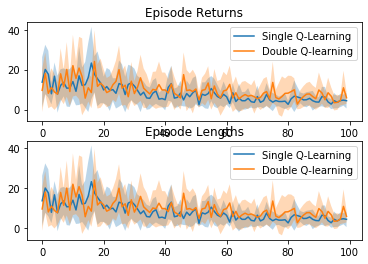

In [183]:
env = GridworldEnv()
env_name = "Gridworld"
experiment(env, env_name=env_name)